# Simulation SO OPM derived from 'A movable unshielded magnetocardiography device' [1]

After careful correction of the 4 pages of math sent by the authors of this paper, we have gotten the following expression :

$$M_{pump} = R_{op} M_0 sin(\theta) cos(\theta) \delta \sqrt{2}\frac{\Gamma sin(\omega t) - \Delta cos(\omega t)}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)} + R_{op} M_0 cos^2(\theta) \frac{\Gamma^2 + \Delta^2}{\Gamma(\Gamma^2+\Delta^2+2\delta^2)}$$

## Imports, functions and general constants

In [16]:
## Imports

import numpy as np
import matplotlib.pyplot as plt

## constants

sigma = 1.082e-13 #m^2 from Table 7, [2]
mu_B = 9.2740100657e-24 # J/T Bohr Magneton
g_F = 0.5006
mu_eff = g_F * mu_B  # g_F depends on hyperfine level (±1/2 for Rb-87)
gamma = 7e9             # Gyromagnetic ratio (Hz/T)
Gamma_natural = 36.10e6 # Natural linewidth (Hz)

## Functions

def R_op(I):
    return Gamma_natural * I / (I + I_sat)

def compute_M_pump(t, R_op_val, M0, delta, theta, Gamma, omega, omega_0):
    """
    Compute the real magnetization signal M_real(t) and its oscillation amplitude.

    Parameters:
        t           : np.array, time vector [s]
        R_op_val    : float, optical pumping rate [Hz]
        M0          : float, maximum magnetization
        delta       : float, RF coupling strength [rad/s]
        theta       : float, angle between B0 and B1 [rad]
        Gamma_tot   : float, total relaxation rate [Hz]
        omega       : float, RF drive angular frequency [rad/s]
        omega_0     : float, Larmor angular frequency [rad/s]

    Returns:
        M_real      : np.array, magnetization signal vs time
        amplitude   : float, oscillation amplitude (half peak-to-peak)
    """
    Gamma_tot = R_op_val + Gamma
    Delta = omega - omega_0  # Detuning

    numerator_My = Gamma_tot * np.sin(omega * t) - Delta * np.cos(omega * t)
    denominator = Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2)

    My = R_op_val * M0 * delta * np.cos(theta) * np.sqrt(2) * numerator_My / denominator
    Mz = R_op_val * M0 * np.cos(theta) * (Gamma_tot**2 + Delta**2) / denominator

    M_pump = np.sin(theta) * My + np.cos(theta) * Mz

    # Compute oscillation amplitude
    amplitude = (np.max(M_pump) - np.min(M_pump))
    DC_val = np.mean(M_pump)

    return M_pump, amplitude, DC_val

def compute_I_PD(t, R_op_val, M0, delta, theta, Gamma, omega, omega_0, n, I, A_beam, z_cell):
    """
    Compute the real magnetization signal M_real(t) and its oscillation amplitude.

    Parameters:
        t           : np.array, time vector [s]
        R_op_val    : float, optical pumping rate [Hz]
        M0          : float, maximum magnetization
        delta       : float, RF coupling strength [rad/s]
        theta       : float, angle between B0 and B1 [rad]
        Gamma_tot   : float, total relaxation rate [Hz]
        omega       : float, RF drive angular frequency [rad/s]
        omega_0     : float, Larmor angular frequency [rad/s]

    Returns:
        M_real      : np.array, magnetization signal vs time
        amplitude   : float, oscillation amplitude (half peak-to-peak)
    """
    Gamma_tot = R_op_val + Gamma
    Delta = omega - omega_0  # Detuning

    numerator_My = Gamma_tot * np.sin(omega * t) - Delta * np.cos(omega * t)
    denominator = Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2)

    My = R_op_val * M0 * delta * np.cos(theta) * np.sqrt(2) * numerator_My / denominator
    Mz = R_op_val * M0 * np.cos(theta) * (Gamma_tot**2 + Delta**2) / denominator

    M_pump = np.sin(theta) * My + np.cos(theta) * Mz

    # Compute oscillation amplitude
    amplitude = (np.max(M_pump) - np.min(M_pump))
    DC_val = np.mean(M_pump)

    #Compute light intensity
    P_t = M_pump / M0
    alpha_0 = n * sigma
    alpha_t = alpha_0 * (1 - P_t)
    I_out = I * np.exp(-alpha_t * z_cell)
    P_out = I_out * A_beam
    I_PD = R * P_out  # Time-varying photodiode current

    return I_PD, M_pump, amplitude, DC_val

## Single computation

In [7]:
# ---- Experimental Parameters that works ----
""" T = 310                    # Cell temperature (K)
P_laser = 2e-6             # Laser power (W)
B0 = 50e-6                 # Static magnetic field (T)
B1 = 10e-6                 # RF magnetic field (T)
theta = np.deg2rad(45)     # Angle (rad)
Gamma = 50e3               # Spin relaxation rate (Hz)
beam_diameter = 3e-3       # Beam diameter (m)
z_cell = 1.6e-3            # Cell length (m)
A_beam = np.pi * (beam_diameter / 2)**2
I_sat = 44.84              # Saturation intensity (W/m²)
R = 0.568                  # Photodiode responsivity (A/W) """

T = 273+80                    # Cell temperature (K)
P_laser = 1e-6             # Laser power (W)
B0 = 163e3/7e9                 # Static magnetic field (T)
B1 = 16e-6                 # RF magnetic field (T)
theta = np.deg2rad(45)     # Angle (rad)
Gamma = 50e3              # Spin relaxation rate (Hz)
beam_diameter = 1e-3       # Beam diameter (m)
z_cell = 1.5e-3            # Cell length (m)
A_beam = np.pi * (beam_diameter / 2)**2
I_sat = 44.84              # Saturation intensity (W/m²)
R = 0.568                  # Photodiode responsivity (A/W)

""" 
T = 273+40                 # Cell temperature (K)
P_laser = 20e-6             # Laser power (W)
B0 = 100e-9                # Static magnetic field (T)
B1 = 100e-6                 # RF magnetic field (T)
theta = np.deg2rad(20)     # Angle (rad) between B0 (0°) and B1 (theta)
Gamma = 50e3               # Spin relaxation rate (Hz)
beam_diameter = 3e-3       # Beam diameter (m)
z_cell = 1.6e-3            # Cell length (m)
A_beam = np.pi * (beam_diameter / 2)**2
I_sat = 44.84              # Saturation intensity (W/m²)
R = 0.568                  # Photodiode responsivity (A/W) """


# ---- Derived Quantities ----
n = (1/T)*10**(21.866+4.312-4040/T) * 10**6                # Vapor density
M0 = n * mu_eff                  # Max magnetization
I = P_laser / A_beam             # Laser intensity
R_op_val = R_op(I)              # Optical pumping rate
Gamma_tot = Gamma + R_op_val    # Total relaxation
omega_0 = gamma * B0              # Larmor frequency (rad/s)
#omega = omega_0 + 0.1*omega_0
delta = (1 / (2 * np.sqrt(2))) * gamma * B1 * np.sin(theta)  # RF coupling

# ---- Time Vector ----
#t_span = [0, 1000/(omega_0)]
#sampling_rate = int(3*omega_0)
#t = np.linspace(t_span[0], t_span[1], sampling_rate)  
t = 1
omega_span = 5 * Gamma_tot
omega = np.linspace(omega_0 - omega_span,
                    omega_0 + omega_span,
                    50000)
Delta = omega - omega_0          

# ---- Time-Dependent Magnetization ----
My = R_op_val * M0 * delta * np.cos(theta) * np.sqrt(2) * (Gamma_tot * np.sin(omega * t) - Delta * np.cos(omega * t)) / (Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2))
Mz = R_op_val * M0 * np.cos(theta) * (Gamma_tot**2 + Delta**2) / (Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2))
M_real = np.sin(theta) * My + np.cos(theta) * Mz

# ---- Polarization and Detection ----
P_t = M_real / M0
alpha_0 = n * sigma
alpha_t = alpha_0 * (1 - P_t)
I_out = I * np.exp(-alpha_t * z_cell)
P_out = I_out * A_beam
I_PD = R * P_out  # Time-varying photodiode current

In [8]:
print('Rb density = n',n)
print('\npumping rate = ', R_op_val)
print('\nRelaxation rate = ',Gamma)

Rb density = n 1.5327315172833894e+18

pumping rate =  996762.4920463251

Relaxation rate =  50000.0


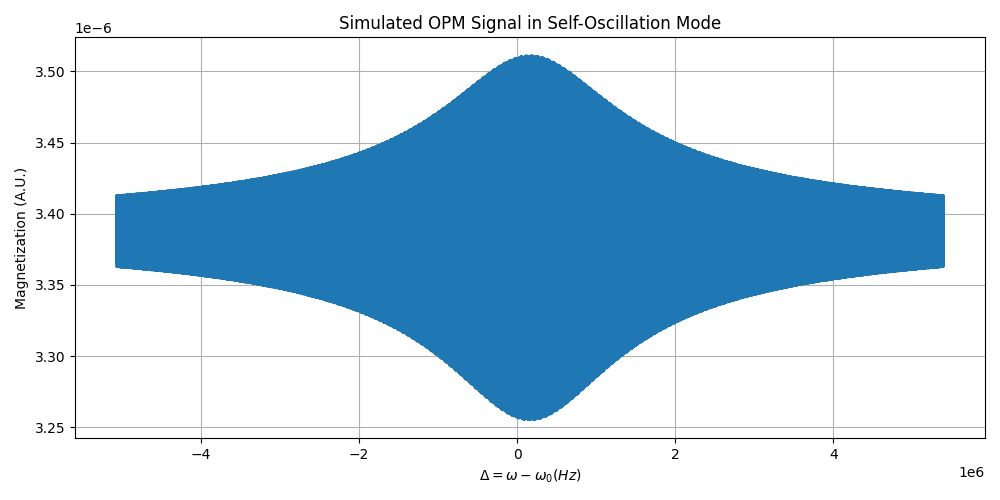

In [10]:
# ---- Plotting ----
%matplotlib widget
plt.figure(figsize=(10, 5))
plt.plot(omega, M_real)#I_PD * 1e9)  # ms vs. nA
plt.xlabel("$\Delta = \omega - \omega_0 (Hz)$")
plt.ylabel("Magnetization (A.U.)")
plt.title("Simulated OPM Signal in Self-Oscillation Mode")
plt.grid(True)
plt.tight_layout()
plt.show()

## Complex susceptibility calculation

In order to compute the dispersive and absorptive behavior of the medium, we need to extract the susceptibility here.

Taking the AC part of $M_{pump}$, we get:

$$M_{pump,AC} = R_{op} M_0 sin(\theta) cos(\theta) \delta \sqrt{2}\frac{\Gamma sin(\omega t) - \Delta cos(\omega t)}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}$$

One can notice that :
$$\Gamma sin(\omega t) - \Delta cos(\omega t) = \Im{((\Gamma-i\Delta)e^{i \omega t})}$$

We know the general form :
$$M_{AC} = A \Im{(\Chi(\Delta)e^{i \omega t})}$$
By identification :
$$A = R_{op} M_0 sin(\theta) cos(\theta) \delta \sqrt{2}$$
$$\Chi(\Delta) = \frac{\Gamma - i\Delta}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}$$

Because of the signal measured is with an MFLI, the DC part plays no role and the $e^{i \omega t}$ is removed to get the X and Y  signals.

### AC magnetization plot

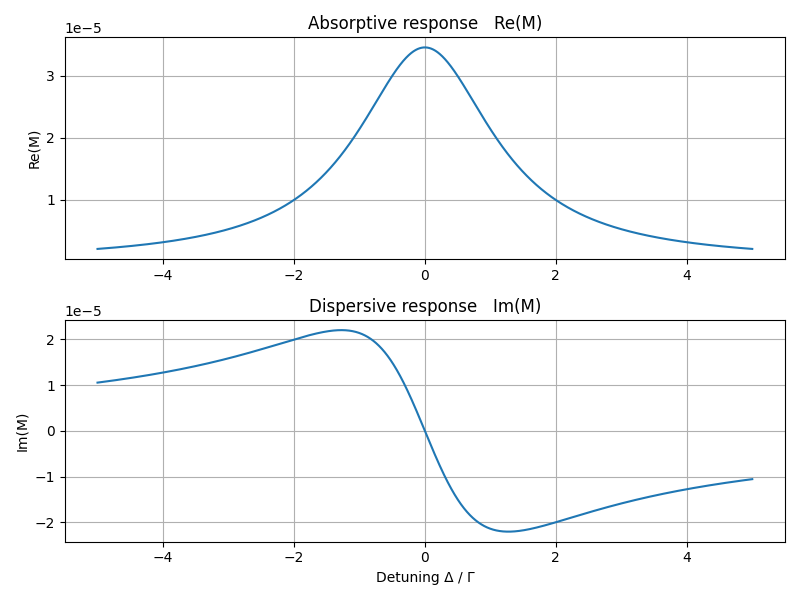

In [22]:
Delta0 = gamma * B0       # resonant frequency
delta = (gamma * B1 / (2*np.sqrt(2))) * np.sin(theta)

Delta = np.linspace(-5*Gamma, 5*Gamma, 30000)

#Prefactor
A = R_op(I) * M0 * np.sin(theta) * np.cos(theta) * delta * np.sqrt(2)

# complex susceptibility
chi = (Gamma - 1j*Delta) / (Gamma*(Gamma**2 + Delta**2 + 2*delta**2))

fig, ax = plt.subplots(2,1, figsize=(8,6))

ax[0].plot(Delta/Gamma, A*np.real(chi))
ax[0].set_title("Absorptive response   Re(M)")
ax[0].set_ylabel("Re(M)")
ax[0].grid(True)

ax[1].plot(Delta/Gamma, A*np.imag(chi))
ax[1].set_title("Dispersive response   Im(M)")
ax[1].set_xlabel("Detuning Δ / Γ")
ax[1].set_ylabel("Im(M)")
ax[1].grid(True)

plt.tight_layout()
plt.show()


### trying to recreate the measured data

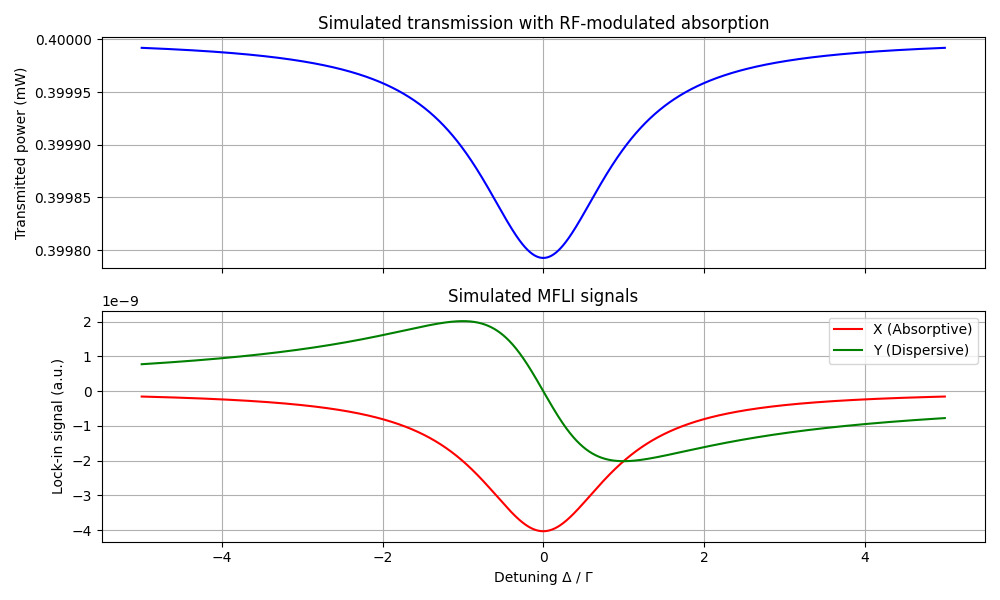

In [57]:
I_in = 1e-3           # Laser power [W]
I_out0 = 0.4e-3       # Transmission without RF
T0 = I_out0 / I_in
OD0 = -np.log(T0)

B0 = 50e-6
B1 = 16e-6
theta = np.deg2rad(45)
Gamma = 50e3
Gamma_natural = 36.10e6
beam_diameter = 1e-3
z_cell = 1.5e-3
A_beam = np.pi*(beam_diameter/2)**2
I_sat = 44.84
mu_B = 9.2740100657e-24
g_F = 0.5006
mu_eff = g_F*mu_B
gamma = 7e9


I_laser = I_in / A_beam
R_op = Gamma_natural * I_laser / (I_laser + I_sat)
Gamma_tot = Gamma + R_op
delta = (gamma * B1 / (2*np.sqrt(2))) * np.sin(theta)

# AC magnetization prefactor
A = R_op * M0 * np.sin(theta) * np.cos(theta) * delta * np.sqrt(2)

# Frequency sweep
Delta = np.linspace(-5*Gamma_tot, 5*Gamma_tot, 3000)

# Complex AC magnetization
chi = (Gamma_tot - 1j*Delta) / (Gamma_tot*(Gamma_tot**2 + Delta**2 + 2*delta**2))
M_AC = A * chi

## The minus sign comes form the fact that the magnetization will orient positively and will translate into more absorption
TIA_gain_MFLI = 1
X = -np.real(M_AC)*TIA_gain_MFLI  # absorptive (dip)
Y = np.imag(M_AC)*TIA_gain_MFLI   # dispersive

OD_mod = OD0 * (1 + np.real(M_AC)/M0)
T = I_in * np.exp(-OD_mod)

# -----------------------------
# Plots
# -----------------------------
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Top plot: transmitted power
ax[0].plot(Delta/Gamma_tot, T*1e3, color='b')
ax[0].set_ylabel("Transmitted power (mW)")
ax[0].set_title("Simulated transmission with RF-modulated absorption")
ax[0].grid(True)

# Bottom plot: X and Y channels
ax[1].plot(Delta/Gamma_tot, X, label='X (Absorptive)', color='r')
ax[1].plot(Delta/Gamma_tot, Y, label='Y (Dispersive)', color='g')
ax[1].set_xlabel("Detuning Δ / Γ")
ax[1].set_ylabel("Lock-in signal (a.u.)")
ax[1].set_title("Simulated MFLI signals")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

In [54]:
np.real(M_AC)

array([1.54943711e-10, 1.55142611e-10, 1.55341890e-10, ...,
       1.55341890e-10, 1.55142611e-10, 1.54943711e-10])

Baseline OD0 = 0.916290731874155


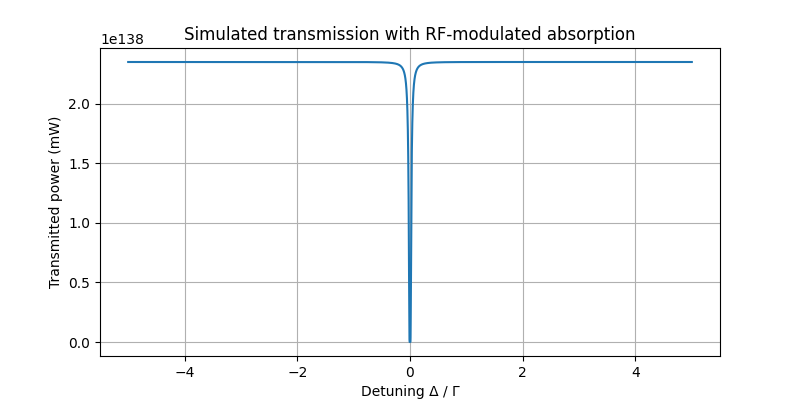

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Measured baseline
I_in = 1e-3      # W
I_out0 = 0.4e-3  # W, measured without RF
T0 = I_out0 / I_in
OD0 = -np.log(T0)
print("Baseline OD0 =", OD0)

# Frequency sweep
Delta = np.linspace(-5*Gamma_tot, 5*Gamma_tot, 30000)  # detuning

DC_term = R_op(I_in) * M0 * np.cos(theta)**2 * (Gamma**2 + Delta**2) / (Gamma * (Gamma**2 + Delta**2 + 2*delta**2))

A = R_op_val * M0 * np.sin(theta) * np.cos(theta) * delta * np.sqrt(2)
chi = (Gamma_tot - 1j*Delta) / (Gamma_tot*(Gamma_tot**2 + Delta**2 + 2*delta**2))
M_complex = A * chi + DC_term
P_delta = np.real(M_complex) / M0   # absorptive modulation

# Modulated optical depth
OD_delta = OD0 * (1 - P_delta)
T_delta = np.exp(-OD_delta)
I_out = I_in * T_delta

plt.figure(figsize=(8,4))
plt.plot(Delta/Gamma_tot, I_out*1e3)
plt.xlabel("Detuning Δ / Γ")
plt.ylabel("Transmitted power (mW)")
plt.title("Simulated transmission with RF-modulated absorption")
plt.grid(True)
plt.show()


Baseline OD0 = 0.916290731874155


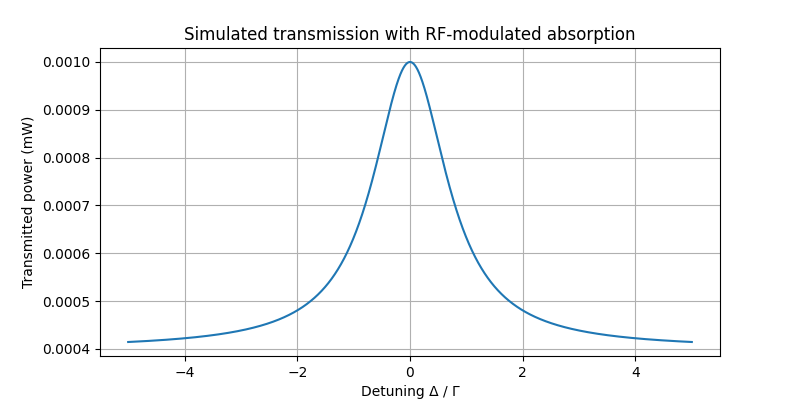

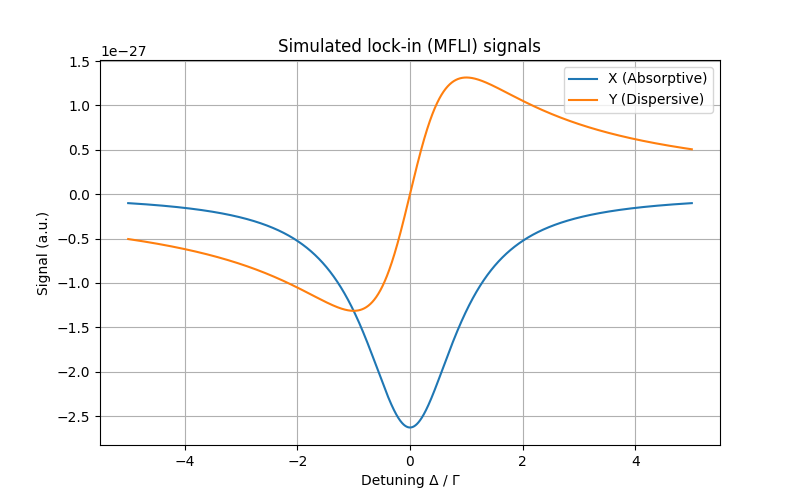

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# --- Experimental inputs -----
# -----------------------------
I_in = 1e-3            # Laser power in [W]
I_out0 = 0.4e-3        # Measured laser power after cell without RF [W]
T0 = I_out0 / I_in     # baseline transmission
OD0 = -np.log(T0)      # baseline optical depth
print("Baseline OD0 =", OD0)

# Magnetic fields
B0 = 163e-6            # static field [T]
B1 = 16e-6             # RF field [T]
theta = np.deg2rad(45) # angle between B0 and B1 [rad]

# Spin relaxation and pumping
Gamma = 50e3           # spin relaxation rate [Hz]
Gamma_natural = 36.10e6 # optical linewidth [Hz]
P_laser = I_in
beam_diameter = 1e-3   # m
z_cell = 1.5e-3        # cell length [m]
A_beam = np.pi*(beam_diameter/2)**2
I_sat = 44.84          # W/m²
R = 0.568              # photodiode responsivity [A/W]

# Constants
sigma0 = 1.082e-13     # cross-section [m²]
mu_B = 9.2740100657e-24
g_F = 0.5006
mu_eff = g_F*mu_B
gamma = 7e9            # Hz/T (gyromagnetic ratio)

# -----------------------------
# --- Derived quantities -----
# -----------------------------
# Laser intensity
I_laser = P_laser / A_beam
R_op_val = Gamma_natural * I_laser / (I_laser + I_sat)  # optical pumping rate [Hz]

Gamma_tot = Gamma + R_op_val
omega_0 = gamma * B0        # Larmor frequency [rad/s]
delta = (gamma * B1 / (2*np.sqrt(2))) * np.sin(theta)  # RF coupling

# DC part
DC_term = R_op_val * M0 * np.cos(theta)**2 * (Gamma**2 + Delta**2) / (Gamma * (Gamma**2 + Delta**2 + 2*delta**2))

# Prefactor for M
A = R_op_val * mu_eff * np.sin(theta) * np.cos(theta) * delta * np.sqrt(2)

# Frequency sweep
Delta = np.linspace(-5*Gamma_tot, 5*Gamma_tot, 30000)

# Complex magnetization
chi = (Gamma_tot + 1j*Delta) / (Gamma_tot*(Gamma_tot**2 + Delta**2 + 2*delta**2))
M_complex = A * chi

# -----------------------------
# --- X and Y signals (MFLI) ---
# -----------------------------
X_signal = -np.real(M_complex)  # absorptive, sign flipped to produce absorption dip
Y_signal = np.imag(M_complex)   # dispersive

# Normalize for optical depth modulation
P_delta = X_signal / np.max(np.abs(X_signal))  # fractional modulation (absorptive)
OD_delta = OD0 * (1 + X_signal / np.max(np.abs(X_signal)))
T_delta = I_in * np.exp(-OD_delta)

I_out = I_in * T_delta

# -----------------------------
# --- Plot transmitted power ---
# -----------------------------
plt.figure(figsize=(8,4))
plt.plot(Delta/Gamma_tot, I_out*1e3)
plt.xlabel("Detuning Δ / Γ")
plt.ylabel("Transmitted power (mW)")
plt.title("Simulated transmission with RF-modulated absorption")
plt.grid(True)
plt.show()

# -----------------------------
# --- Plot X+iY (MFLI) channels ---
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(Delta/Gamma_tot, X_signal, label='X (Absorptive)')
plt.plot(Delta/Gamma_tot, Y_signal, label='Y (Dispersive)')
plt.xlabel("Detuning Δ / Γ")
plt.ylabel("Signal (a.u.)")
plt.title("Simulated lock-in (MFLI) signals")
plt.grid(True)
plt.legend()
plt.show()


In [21]:
import numpy as np

k_B = 1.380649e-23  # J/K

# --- Option 1: If you know vapor pressure p (Pa) at temperature T, use it:
# p_Pa = ...  # supply measured or literature vapor pressure
# n = p_Pa / (k_B * T)

# --- Option 2: Fallback (safe test density) if you don't have p:
# choose a physically plausible test density for warm Rb vapor (adjust if you know better)
n_test = 1e15   # m^-3  (adjust between 1e13 .. 1e17 as needed)
# If your previous n is obviously wrong, override it:
if (n <= 0) or (n > 1e20) or np.isnan(n):
    print("Warning: computed n was suspicious; using fallback n_test =", n_test)
    n = n_test

# recompute derived quantities
alpha_0 = n * sigma          # m^-1
print("alpha_0 (m^-1) =", alpha_0)
print("optical depth alpha_0 * z_cell =", alpha_0 * z_cell)

# compute M_complex the same as before
A = R_op_val * M0 * np.sin(theta) * np.cos(theta) * delta * np.sqrt(2)
chi = (Gamma_tot + 1j*Delta) / (Gamma_tot*(Gamma_tot**2 + Delta**2 + 2*delta**2))
M_complex = A * chi
P_delta = np.real(M_complex) / M0   # use real(M)/M0 as the part that modulates absorption

# Full nonlinear transmission (stable)
alpha_delta = alpha_0 * (1 - P_delta)
log_T = -alpha_delta * z_cell
log_T = np.clip(log_T, -700, 0)   # avoid underflow in exp
T_delta = np.exp(log_T)
I_PD_full = R * P_laser * T_delta

# Small-signal linearized PD change (for sanity checks)
# ΔI ≈ R * A_beam * I * ( -alpha_0 * z * (1 - P_delta) + ... )
# We'll compute the signal proportional to P_delta:
Delta_I_lin = R * P_laser * (alpha_0 * z_cell) * (P_delta)   # proportional to M

# Diagnostics:
print("max |M_complex| =", np.max(np.abs(M_complex)))
print("max P_delta (abs) =", np.max(np.abs(P_delta)))
print("I_PD_full: min, max =", np.min(I_PD_full), np.max(I_PD_full))
print("I_PD_lin: min, max  =", np.min(Delta_I_lin), np.max(Delta_I_lin))


alpha_0 (m^-1) = 165841.55017006272
optical depth alpha_0 * z_cell = 248.76232525509408
max |M_complex| = 1.279799283878884e-07
max P_delta (abs) = 0.01798528662539563
I_PD_full: min, max = 6.209821102988481e-115 4.5846215266783844e-113
I_PD_lin: min, max  = 9.787552585273795e-08 2.541267057705648e-06


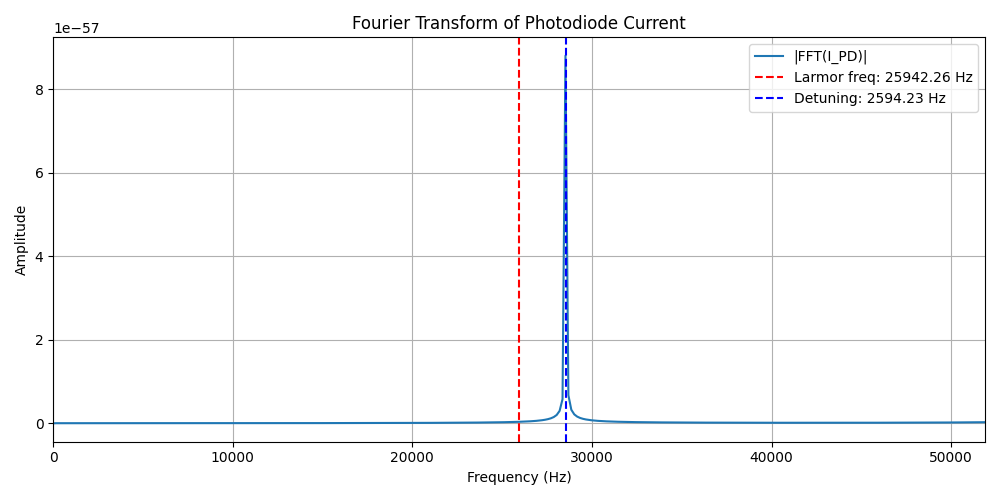

In [31]:
# ---- Fourier Transform of I_PD ----
from scipy.fft import fft, fftfreq, fftshift

# Remove DC component (optional but helps highlight peaks)
signal = I_PD - np.mean(I_PD)

# Perform FT
N = len(t)
dt = t[1] - t[0]
freqs = fftshift(fftfreq(N, d=dt))
spectrum = fftshift(np.abs(fft(signal)))

# Convert angular Larmor frequency to Hz
f_Larmor = omega_0 / (2 * np.pi)
f_detuning = (omega - omega_0) / (2 * np.pi)

# ---- Plotting the FFT ----
plt.figure(figsize=(10, 5))
plt.plot(freqs, spectrum, label="|FFT(I_PD)|")
plt.axvline(f_Larmor, color='r', linestyle='--', label=f"Larmor freq: {f_Larmor:.2f} Hz")
plt.axvline(f_Larmor+f_detuning, color='b', linestyle='--', label=f"Detuning: {f_detuning:.2f} Hz")

plt.title("Fourier Transform of Photodiode Current")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, 2*f_Larmor)  # focus near Larmor peak
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Parameters optimization

### Laser power

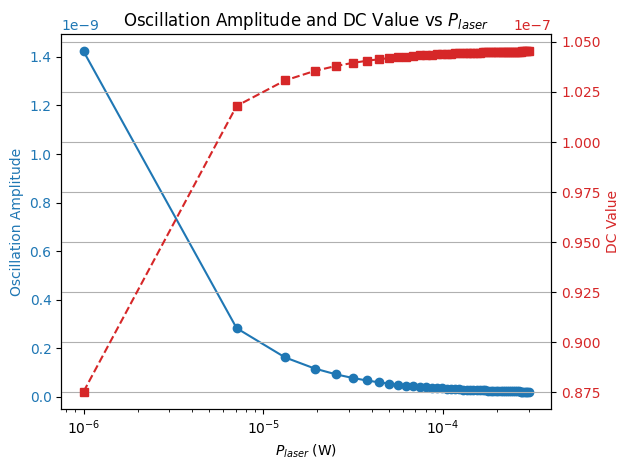

In [ ]:
T = 310                    # Cell temperature (K)
#P_laser = 2e-6             # Laser power (W)
B0 = 5e-6                 # Static magnetic field (T)
B1 = 1e-6                 # RF magnetic field (T)
theta = np.deg2rad(45)     # Angle (rad)
Gamma = 50e3               # Spin relaxation rate (Hz)
beam_diameter = 2e-3       # Beam diameter (m)
z_cell = 1.6e-3            # Cell length (m)
A_beam = np.pi * (beam_diameter / 2)**2
I_sat = 44.84              # Saturation intensity (W/m²)
R = 0.568                  # Photodiode responsivity (A/W)

# ---- Derived Quantities ----
n = (1/T)*10**(21.866+4.312-4040/T) * 10**6                # Vapor density
M0 = n * mu_eff                  # Max magnetization
            # Laser intensity
                                    # Optical pumping rate
#Gamma_tot = Gamma + R_op_val    # Total relaxation
omega_0 = gamma * B0              # Larmor frequency (rad/s)
omega = omega_0 + 0.1*omega_0
delta = (1 / (2 * np.sqrt(2))) * gamma * B1 * np.sin(theta)  # RF coupling
Delta = omega - omega_0          # slight detuning (10%) case

# ---- Time Vector ----
t_span = [0, 1000/(omega_0)]
sampling_rate = int(3*omega_0)
t = np.linspace(t_span[0], t_span[1], sampling_rate)

P_laser = np.linspace(1e-6,300e-6, num=50)
oscillation_amplitude = []
DC_value = []
for i,P_las_i in enumerate(P_laser):
    I = P_las_i / A_beam
    R_op_val = R_op(I)
    _, osc_amp, constant_dc = compute_M_pump(t, R_op_val, M0, delta, theta, Gamma, omega, omega_0)
    oscillation_amplitude.append(osc_amp)
    DC_value.append(constant_dc)

# ---- Plotting ----
fig, ax1 = plt.subplots()

# Left y-axis: Oscillation amplitude
ax1.set_xlabel('$P_{laser}$ (W)')
ax1.set_xscale('log')
ax1.set_ylabel('Oscillation Amplitude', color='tab:blue')
ax1.plot(P_laser, oscillation_amplitude, 'o-', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right y-axis: DC value
ax2 = ax1.twinx()
ax2.set_ylabel('DC Value', color='tab:red')
ax2.plot(P_laser, DC_value, 's--', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Oscillation Amplitude and DC Value vs $P_{laser}$')
plt.grid(True)
plt.tight_layout()
plt.show()

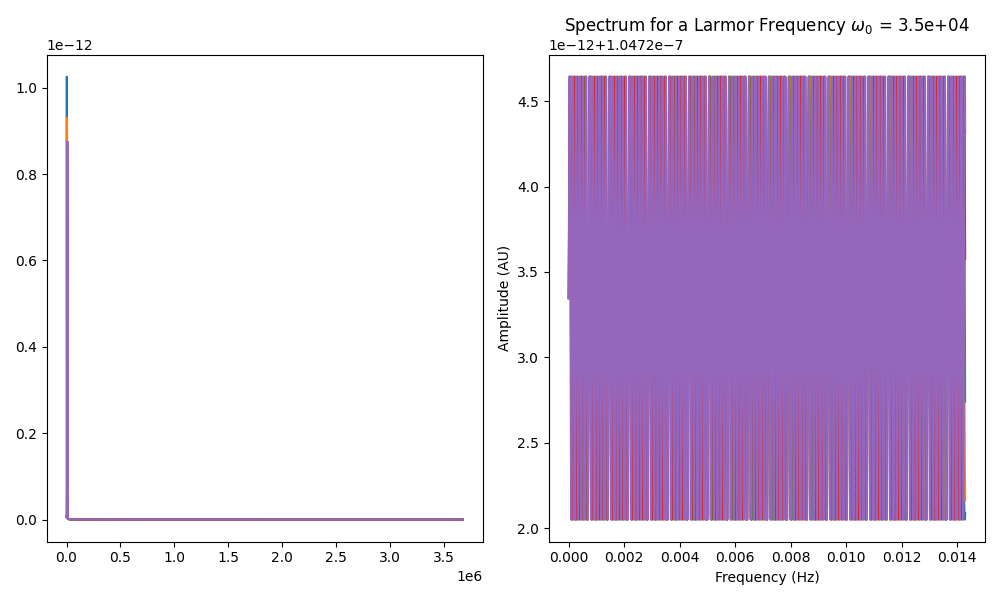

In [17]:
T = 310                    # Cell temperature (K)
P_laser = 2e-6             # Laser power (W)
B0 = 5e-6                 # Static magnetic field (T)
B1 = 0.1e-6                 # RF magnetic field (T)
theta = np.deg2rad(45)     # Angle (rad)
Gamma = 3e3               # Spin relaxation rate (Hz)
beam_diameter = 2e-3       # Beam diameter (m)
z_cell = 1.6e-3            # Cell length (m)
A_beam = np.pi * (beam_diameter / 2)**2
I_sat = 44.84              # Saturation intensity (W/m²)
R = 0.568                  # Photodiode responsivity (A/W)

# ---- Derived Quantities ----
n = (1/T)*10**(21.866+4.312-4040/T) * 10**6                # Vapor density
I = P_laser / A_beam
R_op_val = 2e7
M0 = n * mu_eff                  # Max magnetization
Gamma_tot = Gamma + R_op_val    # Total relaxation
omega_0 = gamma * B0              # Larmor frequency (rad/s)
delta = (1 / (2 * np.sqrt(2))) * gamma * B1 * np.sin(theta)  # RF coupling

# ---- Time Vector ----
t_span = [0, 500/(omega_0)]
sampling_rate = int(3*omega_0)
t = np.linspace(t_span[0], t_span[1], sampling_rate)

# ---- New Section: Detuning Sweep and FFT Analysis ----
detuning_range = np.linspace(-0.5, 0.5, 5)  # -100% to +100%

%matplotlib widget
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))  

signals = []
ffts = []

for det in detuning_range:
    omega = omega_0 * (1 + det)
    I_PD, M_pump_signal, _, _ = compute_I_PD(t, R_op_val, M0, delta, theta, Gamma, omega, omega_0, n, I, A_beam, z_cell)

    # FFT
    I_fft = np.fft.fft(I_PD - np.mean(I_PD))
    freqs = np.fft.fftfreq(len(t), d=t[1] - t[0])
    signals.append(I_PD)
    ffts.append(I_fft)

    
    # Keep only positive frequencies
    mask = freqs > 0
    freqs_pos = freqs[mask]
    fft_mag = np.abs(I_fft[mask])* (2/len(t))

    # Plot FFT curve with color from detuning
    ax[0].plot(freqs_pos, fft_mag)
    ax[1].plot(t, M_pump_signal)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (AU)')
plt.title('Spectrum for a Larmor Frequency $\omega_0$ = {:.1e}'.format(omega_0))
plt.tight_layout()
plt.show()


In [67]:
2e-6/A_beam

0.6366197723675814

In [68]:
omega_0/(2*np.pi)

5570.423008216337

In [25]:
delta

np.float64(174.99999999999997)

In [22]:
omega = omega_0 * (1 + detuning_range)
detuning = omega - omega_0
detuning

array([-17500.,  -8750.,      0.,   8750.,  17500.])

In [61]:
Delta = 5000
Gamma_tot

555358.0036842129

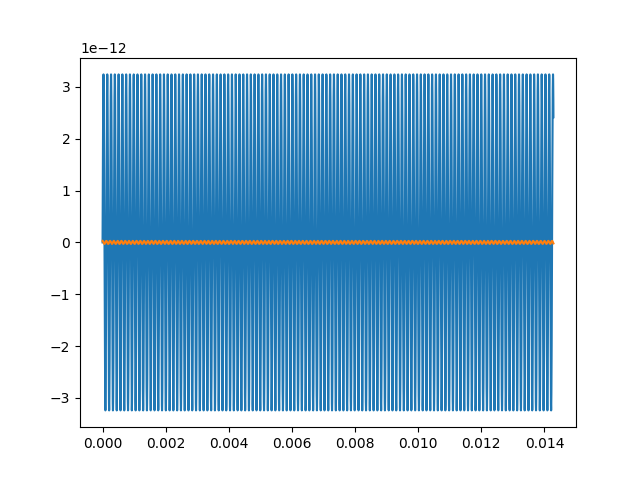

In [62]:
plt.figure()
plt.plot(t,Gamma_tot*np.sin(omega*t)/(Gamma_tot*(Gamma_tot**2 + Delta**2 + 2*delta**2)))
plt.plot(t,Delta*np.cos(omega*t)/(Gamma_tot*(Gamma_tot**2 + Delta**2 + 2*delta**2)))
plt.show()

In [ ]:
# ---- Physical Constants ----
sigma = 1.082e-13  # m^2
mu_B = 9.2740100657e-24  # J/T
g_F = 0.5006
mu_eff = g_F * mu_B
gamma = 7e9               # Hz/T
Gamma_natural = 36.10e6   # Hz

# ---- Functions ----
def R_op(I):
    return Gamma_natural * I / (I + I_sat)

def compute_M_pump(t, R_op_val, M0, delta, theta, Gamma, omega, omega_0):
    Gamma_tot = R_op_val + Gamma
    Delta = omega - omega_0
    denom = Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2)

    My = R_op_val * M0 * delta * np.cos(theta) * np.sqrt(2) * \
         (Gamma_tot * np.sin(omega * t) - Delta * np.cos(omega * t)) / denom
    Mz = R_op_val * M0 * np.cos(theta) * (Gamma_tot**2 + Delta**2) / denom

    M_pump = np.sin(theta) * My + np.cos(theta) * Mz
    amplitude = (np.max(M_pump) - np.min(M_pump))
    DC_val = np.mean(M_pump)
    return M_pump, amplitude, DC_val

# ---- Fixed Experimental Parameters ----
T = 273+50
B0 = 50e-6         # T
B1 = 10e-6         # T
theta = np.deg2rad(45)
beam_diameter = 3e-3
z_cell = 1.6e-3
A_beam = np.pi * (beam_diameter / 2)**2
I_sat = 44.84     # W/m²
R = 0.568

n = (1/T) * 10**(21.866 + 4.312 - 4040/T) * 1e6  # atoms/m³
M0 = n * mu_eff
omega_0 = gamma * B0
omega = omega_0 * 0.01*omega_0
delta = (1 / (2 * np.sqrt(2))) * gamma * B1 * np.sin(theta)

# ---- Time Vector ----
t_span = [0, 1000 / omega_0]
sampling_rate = int(3 * omega_0)
t = np.linspace(t_span[0], t_span[1], sampling_rate)

# ---- Grid Search Ranges ----
P_laser_vals = np.linspace(0.01e-6, 5e-6, num=50)   # W
Gamma_vals = np.linspace(500, 50000, num=50)             # Hz

# ---- Storage Arrays ----
osc_amp_grid = np.zeros((len(Gamma_vals), len(P_laser_vals)))
dc_val_grid = np.zeros_like(osc_amp_grid)

# ---- Grid Computation ----
for i, Gamma_i in enumerate(Gamma_vals):
    for j, P_las_j in enumerate(P_laser_vals):
        I = P_las_j / A_beam
        R_op_val = R_op(I)
        _, amp, dc = compute_M_pump(t, R_op_val, M0, delta, theta, Gamma_i, omega, omega_0)
        osc_amp_grid[i, j] = amp
        dc_val_grid[i, j] = dc



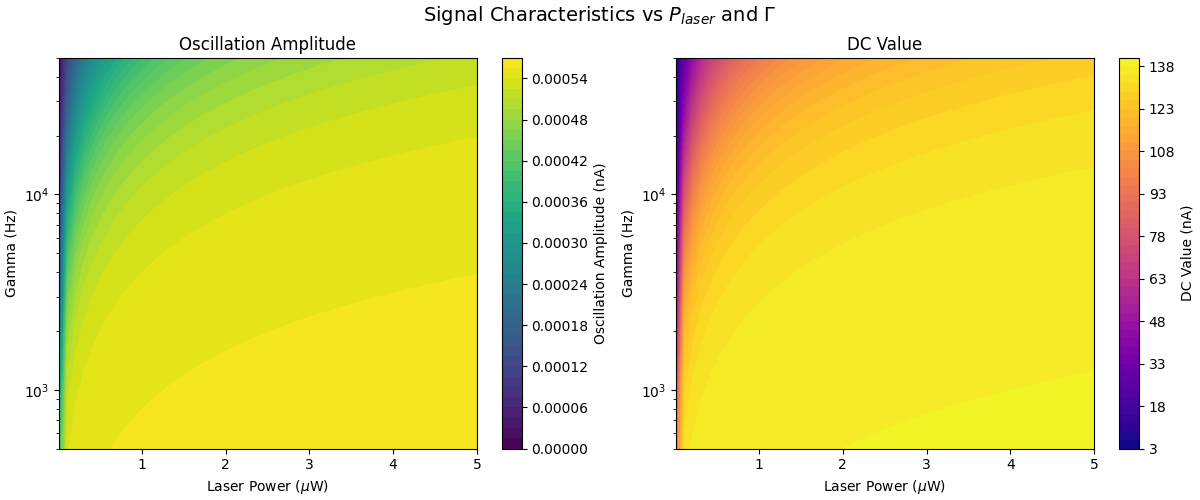

In [ ]:
# Create figure with 1 row and 2 columns of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# ---- Plot Oscillation Amplitude ----
c1 = ax1.contourf(P_laser_vals * 1e6, Gamma_vals, osc_amp_grid * 1e9, levels=50, cmap='viridis')
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel('Laser Power ($\mu$W)')
ax1.set_ylabel('Gamma (Hz)')
fig.colorbar(c1, ax=ax1, label='Oscillation Amplitude (nA)')
ax1.set_title('Oscillation Amplitude')

# ---- Plot DC Value ----
c2 = ax2.contourf(P_laser_vals * 1e6, Gamma_vals, dc_val_grid * 1e9, levels=50, cmap='plasma')
ax2.set_xscale('linear')
ax2.set_yscale('log')
ax2.set_xlabel('Laser Power ($\mu$W)')
ax2.set_ylabel('Gamma (Hz)')
fig.colorbar(c2, ax=ax2, label='DC Value (nA)')
ax2.set_title('DC Value')

plt.suptitle('Signal Characteristics vs $P_{laser}$ and $\\Gamma$', fontsize=14)
plt.show()

In [ ]:
import numpy as np

# ... [Keep your existing constants and functions unchanged] ...

# ---- Fixed Experimental Parameters ----
T = 273 + 50
B0 = 50e-6         # T
theta = np.deg2rad(45)
beam_diameter = 3e-3
z_cell = 1.6e-3
A_beam = np.pi * (beam_diameter / 2) ** 2
I_sat = 44.84     # W/m²
R = 0.568

n = (1 / T) * 10 ** (21.866 + 4.312 - 4040 / T) * 1e6  # atoms/m³
M0 = n * mu_eff
omega_0 = gamma * B0
omega = omega_0 * 0.01 * omega_0  # Slight detuning

# ---- Time Vector ----
t_span = [0, 1000 / omega_0]
sampling_rate = int(3 * omega_0)
t = np.linspace(t_span[0], t_span[1], sampling_rate)

# ---- Grid Search Ranges ----
P_laser_vals = np.linspace(0.01e-6, 5e-6, num=10)   # W
Gamma_vals = np.linspace(500, 50000, num=10)        # Hz
B1_vals = np.linspace(10e-9, 100e-6, num=5)        # T

# ---- Storage Arrays ----
osc_amp_grid = np.zeros((len(Gamma_vals), len(P_laser_vals), len(B1_vals)))
dc_val_grid = np.zeros_like(osc_amp_grid)

# ---- Grid Computation ----
for k, B1_i in enumerate(B1_vals):
    delta = (1 / (2 * np.sqrt(2))) * gamma * B1_i * np.sin(theta)  # update delta for each B1
    for i, Gamma_i in enumerate(Gamma_vals):
        for j, P_las_j in enumerate(P_laser_vals):
            I = P_las_j / A_beam
            R_op_val = R_op(I)
            _, amp, dc = compute_M_pump(t, R_op_val, M0, delta, theta, Gamma_i, omega, omega_0)
            osc_amp_grid[i, j, k] = amp
            dc_val_grid[i, j, k] = dc


In [49]:
flat_B1 = B1_vals.flatten()
np.savetxt('B1_values.txt', flat_B1)

flat_Gamma = Gamma_vals.flatten()
np.savetxt('Gamma_values.txt', flat_Gamma)

flat_P_laser = P_laser_vals.flatten()
np.savetxt('P_laser_values.txt', flat_P_laser)

flat_data = osc_amp_grid.flatten()
np.savetxt('oscillation_amplitude.txt', flat_data)
np.save('osc_amp_shape.npy', np.array(osc_amp_grid.shape))

flat_data_dc = dc_val_grid.flatten()
np.savetxt('DC_amplitude.txt',flat_data_dc)
np.save('dc_amp_shape.npy', np.array(dc_val_grid.shape))

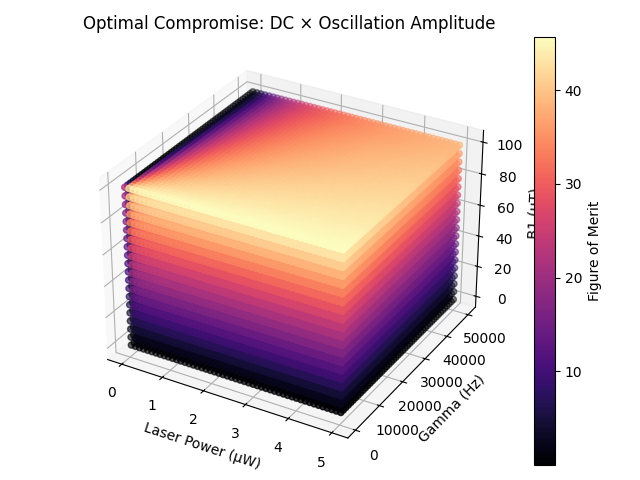

: 

In [ ]:

Gamma_mesh, P_laser_mesh, B1_mesh = np.meshgrid(Gamma_vals, P_laser_vals, B1_vals, indexing='ij')

FoM = (osc_amp_grid * dc_val_grid)  # simple product
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(P_laser_mesh.flatten() * 1e6,
                Gamma_mesh.flatten(),
                B1_mesh.flatten() * 1e6,
                c=FoM.flatten(),
                cmap='magma')

ax.set_xlabel('Laser Power (μW)')
ax.set_ylabel('Gamma (Hz)')
ax.set_zlabel('B1 (μT)')
fig.colorbar(sc, label='Figure of Merit')
plt.title('Optimal Compromise: DC × Oscillation Amplitude')
plt.tight_layout()
plt.show()


# Sources

[1] : 'A movable unshielded magnetocardiography system', W. Xiao et al <br>
[2] : 'Rubidium 87 D Line Data', Daniel A. Steck <br>

# Appendix

## Full derivation of the $M_{pump}$ expression

We start with the definition of our referential.
$\vec{B_0}$, the field to be measured, is expressed as $\vec{B_0} = B_0 \vec{e_z}$.
The pump laser, $\vec{B_1}$ field and thus $\vec{M_0}$ the maximum theoretical magnetization are along $\vec{n} = sin(\theta)\vec{e_y} + cos(\theta) \vec{e_z}$

The general Bloch equation is as follows:
$$ \partial_t \vec{M} = \gamma \vec{M} \wedge \vec{B} - \Gamma_0 \vec{M} + R_{op} \left(M_0 \vec{n} - \vec{M} \right)$$

First approximation, we consider $B_1 \ll B_0$, hence:
\begin{align*}
    \vec{B} & = B_0 \vec{e}_z + B_1 cos(\omega t) \vec{n} \\
            & = \left(B_0 + B_1 cos(\theta) cos(\omega t) \right) \vec{e}_z + B_1 sin(\theta) cos(\omega t) \vec{e}_y\\
            & \approx B_0 \vec{e}_z + B_1 sin(\theta)cos(\omega t) \vec{e}_y\\
            & = B_0 \vec{e}_z + \frac{B_1}{2}sin(\theta) \left( e^{-i \omega t} + e^{i \omega t} \right)\vec{e}_y\\
\end{align*}



Next, we will express our probably in a rotating frame. We thus need to defined spherical basis and rotation matrix to apply to our general equation.
We now change referential and define the following spherical basis:

$$\begin{cases} 
\vec{e}_{+1} = -\frac{1}{\sqrt{2}} (\vec{e}_x + i \vec{e}_y) \\
\vec{e}_{+1} = \frac{1}{\sqrt{2}} (\vec{e}_x - i \vec{e}_y) \\
\vec{e}_0 = \vec{e}_z
\end{cases}
$$

And define the rotation matrix and its infinitesimal generator as follows:
$$\hat{R}_z = e^{\omega t \hat{J}_z} = \begin{pmatrix} cos(\omega t) & -sin(\omega t) & 0 \\ sin(\omega t) & cos(\omega t) & 0 \\ 0 & 0 & 1 \end{pmatrix}

Additionnally, we define the following generators:
$$\begin{cases} 
\hat{J}_{x} = \begin{pmatrix} 0 & 0 & 0 \\ 0 & 0 & -1 \\ 0 & 1 & 0 \end{pmatrix} \\
\hat{J}_{y} = \begin{pmatrix} 0 & 0 & 1 \\ 0 & 0 & 0 \\ -1 & 0 & 0 \end{pmatrix} \\
\hat{J}_z = \begin{pmatrix} 0 & -1 & 0 \\ 1 & 0 & 0 \\ 0 & 0 & 0 \end{pmatrix}
\end{cases}
$$

The effect of $\hat{R}_z$ on our vectors is the following :
$$\hat{R}_z \vec{e}_z = \vec{e}_z \; ; \; \hat{R}_z \vec{e}_{\pm 1} = e^{\mp i\omega t}\vec{e}_{\pm 1}$$

From now on, I will use $\hat{R} = \hat{R}_z$

We can deduce :
$$\vec{e}_y = -\frac{i}{\sqrt{2}} \left(\vec{e}_{+1} + \vec{e}_{-1} \right)$$
thus:
$$\hat{R}\vec{e}_y = \frac{i}{\sqrt{2}} \left(e^{- i \omega t}\vec{e}_{+1} + e^{i \omega t} \vec{e}_{-1} \right)$$

from there, we can deduce:
\begin{align*}
    \hat{R}\vec{n} &= \hat{R} (sin(\theta)\vec{e_y} + cos(\theta) \vec{e_z})\\
                   &= \frac{i}{\sqrt{2}} sin(\theta) \left(e^{- i \omega t}\vec{e}_{+1} + e^{i \omega t} \vec{e}_{-1} \right) + cos(\theta) \vec{e}_0
\end{align*}

And finally get 
\begin{align*}
    \hat{R}\vec{B} & = B_0 \vec{e}_0 + \frac{i}{2\sqrt{2}} B_1 sin(\theta) \left(e^{- i \omega t} + e^{i \omega t}  \right)\left(e^{- i \omega t}\vec{e}_{+1} + e^{i \omega t} \vec{e}_{-1} \right) \\
                   & = B_0 \vec{e}_0 + \frac{i}{2\sqrt{2}} B_1 sin(\theta) \left[e^{- i 2 \omega t}\vec{e}_{+1} + \vec{e}_{-1} + \vec{e}_{+1} + e^{i 2 \omega t} \vec{e}_{-1} \right]
\end{align*}

And applying the rotating wave approximation, we neglect the terms in $2 \omega$

$$\hat{R}\vec{B} \approx B_0 \vec{e}_0 + \frac{i}{2\sqrt{2}} B_1 sin(\theta) \left( \vec{e}_{+1}+\vec{e}_{-1} \right)$$

Defining $\hat{R}\vec{M} = \vec{M}'$, we now have :
\begin{align*}
    \hat{R} \left(\vec{M}\wedge \vec{B} \right) &= \left(\hat{R}\vec{M} \right) \wedge \left(\hat{R}\vec{B} \right)\\
                                                &= \vec{M}' \wedge B_0 \vec{e}_0 + \frac{i}{2\sqrt{2}} B_1 sin(\theta) \left( \vec{e}_{+1}+\vec{e}_{-1} \right)
\end{align*}

Using the identity $\vec{M}' \wedge \vec{B}' = - \left(\hat{J}\vec{B}' \right) \vec{M}'$, we expand into:

\begin{align*}
    \vec{M}' \wedge \vec{B}' &= -\left(B_x' \hat{J}_x + B_y' \hat{J}_y + B_z' \hat{J}_z \right) \vec{M}' \\
                             &= -\left(B_0 \hat{J}_z + \frac{B_1}{2}sin(\theta) \hat{J}_y \right)\vec{M}' 
\end{align*}

Note : the $\frac{i}{\sqrt{2}}$ is missing here due to the equivalence between $\hat{J}_y$ and $\hat{J}_{+1} and \hat{J}_{-1}$, but we will reexpress it in these terms anyway.

$$\hat{J}_y = \frac{i}{\sqrt{2}} \left(\hat{J}_{+1}+\hat{J}_{-1} \right)$$
$$\hat{J}_z = \hat{J}_0$$

finally leading us to 

\begin{align*}
    \vec{M}' \wedge \vec{B}' &= -\vec{M}' B_0 \hat{J}_0 - \frac{i B_1}{2 \sqrt{2}} sin(\theta) \left(\hat{J}_{+1} + \hat{J}_{-1} \right) \vec{M}'
\end{align*}

We are now interested in the time derivative of $\vec{M}'$ and turn it into:
$$\partial_t \vec{M}' = \partial_t \hat{R} \vec{M} + \hat{R} \partial_t \vec{M}$$

$$\partial_t \hat{R} = \partial_t e^{\omega t \hat{J}_z} = \omega \hat{J}_z \hat{R} $$

\begin{align*}
    \partial_t \vec{M}' &= \omega \hat{J}_z \hat{R} \vec{M} + \hat{R} \left( \gamma \vec{M} \wedge \vec{B} - \Gamma_0 \vec{M} + R_{op} M_0 \vec{n} - R_{op} \vec{M} \right)\\
                        &= \omega \hat{J}_z \hat{R} \vec{M} + \left[ -\gamma \vec{M}' B_0 \hat{J}_0 - \frac{i \gamma B_1}{2 \sqrt{2}} sin(\theta) \left(\hat{J}_{+1} + \hat{J}_{-1} \right) \vec{M}' \right] - \Gamma_0 \vec{M}' + R_{op} M_0 \hat{R} \vec{n} - R_{op} \vec{M}'\\
                        &= \left[ \left(\omega - \gamma B_0 \right) \hat{J}_0 - \frac{i \gamma B_1}{2 \sqrt{2}} sin(\theta) \left(\hat{J}_{+1} + \hat{J}_{-1} \right) - \Gamma_0 - R_{op} \right] \vec{M}' + R_{op} M_0 \left[\frac{i}{\sqrt{2}} sin(\theta) \left(e^{- i \omega t}\vec{e}_{+1} + e^{i \omega t} \vec{e}_{-1} \right) + cos(\theta) \vec{e}_0 \right]
\end{align*}

We now define the following :
$$\Delta = \omega - \gamma B_0 \; ; \; \delta = \frac{1}{2 \sqrt{2}} \gamma B_1 sin(\theta) \; ; \; \Gamma = \Gamma_0+R_{op}$$

follows:

$$\partial_t \vec{M}' = \left[\Delta \hat{J}_0 - i\delta \left(\hat{J}_{+1} + \hat{J}_{-1} \right) - \Gamma \right]\vec{M}' + R_{op} M_0 \left[\frac{i}{\sqrt{2}} sin(\theta) \left(e^{- i \omega t}\vec{e}_{+1} + e^{i \omega t} \vec{e}_{-1} \right) + cos(\theta) \vec{e}_0 \right]$$

Assuming that $\Delta \ll \omega$, we neglect the terms in $\omega t$.

$$\partial_t \vec{M}' = \left[\Delta \hat{J}_0 - i\delta \left(\hat{J}_{+1} + \hat{J}_{-1} \right) - \Gamma \right]\vec{M}' + R_{op} M_0 \frac{i}{\sqrt{2}} sin(\theta)  cos(\theta) \vec{e}_0$$

We will now assume the form :
$$\partial_t \vec{M}' = \hat{A} \vec{M}' + R_{op} M_0 cos(\theta) \vec{e}_0$$
with $$\hat{A} = \Delta \hat{J}_0 - i\delta \left(\hat{J}_{+1} + \hat{J}_{-1} \right) - \Gamma \mathcal{I} $$

We now must explicit the form of these generators:
$$J_{+1} = -\frac{1}{\sqrt{2}} \left(\hat{J}_x + i \hat{J}_y \right) = -\frac{1}{\sqrt{2}} \left(\begin{pmatrix} 0 & 0 & 0 \\ 0 & 0 & -1 \\ 0 & 1 & 0 \end{pmatrix} + i \begin{pmatrix} 0 & 0 & 1 \\ 0 & 0 & 0 \\ -1 & 0 & 0 \end{pmatrix} \right)$$

$$J_{+1} = -\frac{1}{\sqrt{2}} \begin{pmatrix} 0 & 0 & i \\ 0 & 0 & -1 \\ -i & 1 & 0 \end{pmatrix}$$

$$J_{-1} = \frac{1}{\sqrt{2}} \left(\hat{J}_x - i \hat{J}_y \right) = \frac{1}{\sqrt{2}} \left(\begin{pmatrix} 0 & 0 & 0 \\ 0 & 0 & -1 \\ 0 & 1 & 0 \end{pmatrix} - i \begin{pmatrix} 0 & 0 & 1 \\ 0 & 0 & 0 \\ -1 & 0 & 0 \end{pmatrix} \right)$$

$$J_{-1} = \frac{1}{\sqrt{2}} \begin{pmatrix} 0 & 0 & -i \\ 0 & 0 & -1 \\ i & 1 & 0 \end{pmatrix}$$

$$\hat{J}_0 = \hat{J}_z = \begin{pmatrix} 0 & -1 & 0 \\ 1 & 0 & 0 \\ 0 & 0 & 0 \end{pmatrix}

hence:

\begin{align*}
    \hat{A} &= \Delta \begin{pmatrix} 0 & -1 & 0 \\ 1 & 0 & 0 \\ 0 & 0 & 0 \end{pmatrix} - i\delta \left(-\frac{1}{\sqrt{2}} \begin{pmatrix} 0 & 0 & i \\ 0 & 0 & -1 \\ -i & 1 & 0 \end{pmatrix} + \frac{1}{\sqrt{2}} \begin{pmatrix} 0 & 0 & -i \\ 0 & 0 & -1 \\ i & 1 & 0 \end{pmatrix} \right) - \Gamma \mathcal{I} \\
            &= \begin{pmatrix} 0 & -\Delta & 0 \\ \Delta & 0 & 0 \\ 0 & 0 & 0 \end{pmatrix} - i \delta \left( \begin{pmatrix} 0 & 0 & -\frac{i}{\sqrt{2}} \\ 0 & 0 & \frac{1}{\sqrt{2}} \\ \frac{i}{\sqrt{2}} & -\frac{1}{\sqrt{2}} & 0 \end{pmatrix} + \begin{pmatrix} 0 & 0 & -\frac{i}{\sqrt{2}} \\ 0 & 0 & -\frac{1}{\sqrt{2}} \\ \frac{i}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 \end{pmatrix} \right) - \begin{pmatrix} \Gamma & 0 & 0 \\ 0 & \Gamma & 0 \\ 0 & 0 & \Gamma \end{pmatrix} \\
            &= \begin{pmatrix} 0 & -\Delta & 0 \\ \Delta & 0 & 0 \\ 0 & 0 & 0 \end{pmatrix} - i\delta \begin{pmatrix} 0 & 0 & -\frac{2i}{\sqrt{2}} \\ 0 & 0 & 0 \\ \frac{2i}{\sqrt{2}} & 0 & 0 \end{pmatrix} - \begin{pmatrix} \Gamma & 0 & 0 \\ 0 & \Gamma & 0 \\ 0 & 0 & \Gamma \end{pmatrix} \\
            &= \begin{pmatrix} -\Gamma & -\Delta & -\delta\sqrt{2} \\ \Delta & -\Gamma & 0 \\ \delta\sqrt{2} & 0 & -\Gamma \end{pmatrix}
\end{align*}

Assuming the steady-state solution, we have the follwing expression:

$$\vec{M}' = -R_{op}M_0 cos(\theta) \hat{A}^{-1} \vec{e_z}$$

With the calculations of $\hat{A}^{-1}$:

$$det(\hat{A}) = -\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)$$
$$adj(\hat{A}) = \begin{pmatrix} \Gamma^2 & -\Gamma \Delta & -\Gamma \delta\sqrt{2} \\ \Gamma\Delta & \Gamma^2 + 2\delta^2 & -\Delta \delta \sqrt{2} \\ \Gamma \delta \sqrt{2} & \Delta \delta \sqrt{2} & \Gamma^2 + \Delta^2 \end{pmatrix}$$
$$\hat{A}^{-1} = \frac{1}{-\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)} \begin{pmatrix} \Gamma^2 & -\Gamma \Delta & -\Gamma \delta\sqrt{2} \\ \Gamma\Delta & \Gamma^2 + 2\delta^2 & -\Delta \delta \sqrt{2} \\ \Gamma \delta \sqrt{2} & \Delta \delta \sqrt{2} & \Gamma^2 + \Delta^2 \end{pmatrix}$$


We can now deduce :

$$\vec{M}' = \frac{R_{op} M_0 cos(\theta)}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)} \begin{pmatrix} -\Gamma \delta \sqrt{2} \\ -\Delta \delta \sqrt{2} \\ \Gamma^2+\Delta^2 \end{pmatrix}$$



\begin{cases}
    M_x' = R_{op} M_0 cos(\theta)\sqrt{2} \frac{-\Gamma \delta}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}\\
    M_y' = R_{op} M_0 cos(\theta)\sqrt{2} \frac{-\Delta \delta}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}\\
    M_z' = R_{op} M_0 cos(\theta) \frac{\Gamma^2+ \Delta^2}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}
\end{cases}

Coming back to the lab referential $\vec{M} = \hat{R}^{-1} \vec{M}'$
$$\hat{R}^{-1} = \begin{pmatrix} cos(\omega t) & sin(\omega t) & 0 \\ -sin(\omega t) & cos(\omega t) & 0 \\ 0 & 0 & 1 \end{pmatrix}

$$\begin{pmatrix} M_x \\ M_y \\ M_z \end{pmatrix} = \begin{pmatrix} cos(\omega t) & sin(\omega t) & 0 \\ -sin(\omega t) & cos(\omega t) & 0 \\ 0 & 0 & 1 \end{pmatrix} \begin{pmatrix} M_x' \\ M_y' \\ M_z' \end{pmatrix} = \begin{pmatrix} cos(\omega t) M_x' + sin(\omega t) M_y' \\ -sin(\omega t) M_x' + cos(\omega t) M_y' \\ M_z' \end{pmatrix}$$



We thus find :

$$M_y = R_{op} M_0 cos(\theta) \delta \sqrt{2} \frac{\Gamma sin(\omega t)-\Delta cos(\omega t)}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}$$
$$M_z = R_{op} M_0 cos(\theta) \frac{\Gamma^2+ \Delta^2}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}$$

Finally, $M_{pump} = sin(\theta) M_y + cos(\theta) M_z$ 
$$M_{pump} = R_{op} M_0 sin(\theta)cos(\theta) \delta \sqrt{2} \frac{\Gamma sin(\omega t)-\Delta cos(\omega t)}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)} + R_{op} M_0 cos^2(\theta) \frac{\Gamma^2+ \Delta^2}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}